# NAIP Inference and Similarity Search with Clay v1

This notebook walks through Clay model v1 inference on [NAIP (National Agriculture Imagery Program) data](https://naip-usdaonline.hub.arcgis.com/) and similarity search. The workflow includes loading and preprocessing data from STAC, tiling the images and encoding metadata, generating embeddings and querying across them for similar representations. The NAIP data comes in annual composites. We are using data from one year within a sampled region in San Francisco, California.

The workflow includes the following steps:

1. **Loading and Preprocessing Data**:
    - Connect to a STAC (SpatioTemporal Asset Catalog) to query and download NAIP imagery for a specified region and time period.
    - Preprocess the downloaded imagery, including tiling the images and extracting metadata.

2. **Generating Embeddings**:
    - Use a pretrained Clay model to generate embeddings for the preprocessed image tiles.

3. **Saving Embeddings**:
    - Save the generated embeddings along with the associated image data and select metadata in parquet format.

4. **Similarity Search**:
    - Load the saved embeddings into a LanceDB database.
    - Perform a similarity search by querying the database with a randomly selected embedding.
    - Retrieve and display the top similar images based on the similarity search.

In [1]:
import sys

sys.path.append("../") # Model src
sys.path.append("../../stacchip/") 

In [3]:
# %pip install stacchip ==0.1.33

In [37]:
import datetime
import glob
import math
import os
import random
import requests

import geopandas as gpd
import lancedb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystac_client
import shapely
from box import Box
from shapely.geometry import box, Polygon
import torch
import yaml
from pyproj import Transformer
from rasterio.io import MemoryFile
from stacchip.chipper_mod import Chipper
from stacchip.indexer import NoStatsChipIndexer
from stacchip.processors.prechip import normalize_timestamp
from torchvision.transforms import v2

from src.model import ClayMAEModule

In [5]:
# Define the platform name and year for the NAIP data
PLATFORM_NAME = "naip"
YEAR = 2020

In [6]:
# Query STAC catalog for NAIP data
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

In [7]:
# Perform a search on the STAC catalog,
# specifying the collection to search within (NAIP data),
# defining the bounding box for the search area (San Francisco region), and
# setting the date range for the search (entire year 2020).
# Also limit the search to a maximum of 100 items.
items = catalog.search(
    collections=[PLATFORM_NAME],
    bbox=[-122.6, 37.6, -122.35, 37.85],
    datetime=f"{YEAR}-01-01T00:00:00Z/{YEAR+1}-01-01T00:00:00Z",
    max_items=100,
)

# Convert the search results to an item collection
items = items.item_collection()

# Convert the item collection to a list for easier manipulation
items_list = list(items)

# Randomly shuffle the list of items to ensure random sampling
random.shuffle(items_list)

In [8]:
def get_bounds_centroid(url: str):
    """
    Retrieve the bounds and centroid of an image from its URL.

    Parameters:
    url (str): The URL of the image.

    Returns:
    tuple: Bounds coordinates and centroid coordinates.
    """
    response = requests.get(url)
    response.raise_for_status()

    with MemoryFile(response.content) as memfile:
        with memfile.open() as src:
            bounds = src.bounds
            transformer = Transformer.from_crs(src.crs, 4326)
            # Calculate centroid
            centroid_x = (bounds.left + bounds.right) / 2
            centroid_y = (bounds.top + bounds.bottom) / 2
            centroid_x, centroid_y = transformer.transform(centroid_x, centroid_y)
            bounds_b, bounds_l = transformer.transform(bounds.left, bounds.bottom)
            bounds_t, bounds_r = transformer.transform(bounds.right, bounds.top)
            return [bounds_b, bounds_l, bounds_t, bounds_r], centroid_x, centroid_y

In [19]:
chip_images = []  # List to hold chip pixels
chip_bounds = []  # List to hold chip bounds

In [ ]:
for item in items_list[:2]:
    print(f"Working on {item}")

    # Index the chips in the item
    indexer = NoStatsChipIndexer(item)

    # Instantiate the chipper
    chipper = Chipper(
        indexer, asset_blacklist=["thumbnail", "tilejson", "rendered_preview"]
    )

    # Get 5 randomly sampled chips from the total
    # number of chips within this item's entire image
    for chip_id in random.sample(range(0, len(chipper)), 25):
        print(chipper[chip_id])
        x_index, y_index, chip = chipper[chip_id]
        chip_images.append(chip["image"])
        chip_bounds.append(indexer.get_chip_bbox(x_index, y_index))

In [ ]:
for item in items_list[:2]:
    print(f"Working on {item}")

    # Index the chips in the item
    indexer = NoStatsChipIndexer(item)

    # Obtain the item bounds and centroid
    bounds, centroid_x, centroid_y  = get_bounds_centroid(item.assets["image"].href)
    print(f"Bounds coordinates: {bounds}, centroid coordinates: {centroid_x}, {centroid_y}")

    # Instantiate the chipper
    chipper = Chipper(indexer, asset_blacklist=["metadata"])

    # Get 5 randomly sampled chips from the total
    # number of chips within this item's entire image
    for chip_id in random.sample(range(0, len(chipper)), 5):
        chip_images.append(chipper[chip_id]["image"])
        chip_bounds.append(bounds)

Visualize a generated image chip.

In [ ]:
fig, ax = plt.subplots(1, 1, gridspec_kw={"wspace": 0.01, "hspace": 0.01}, squeeze=True)

chip = chip_images[-1]

# Visualize the data
ax.imshow(chip[:3].swapaxes(0, 1).swapaxes(1, 2))

plt.tight_layout()
plt.show()

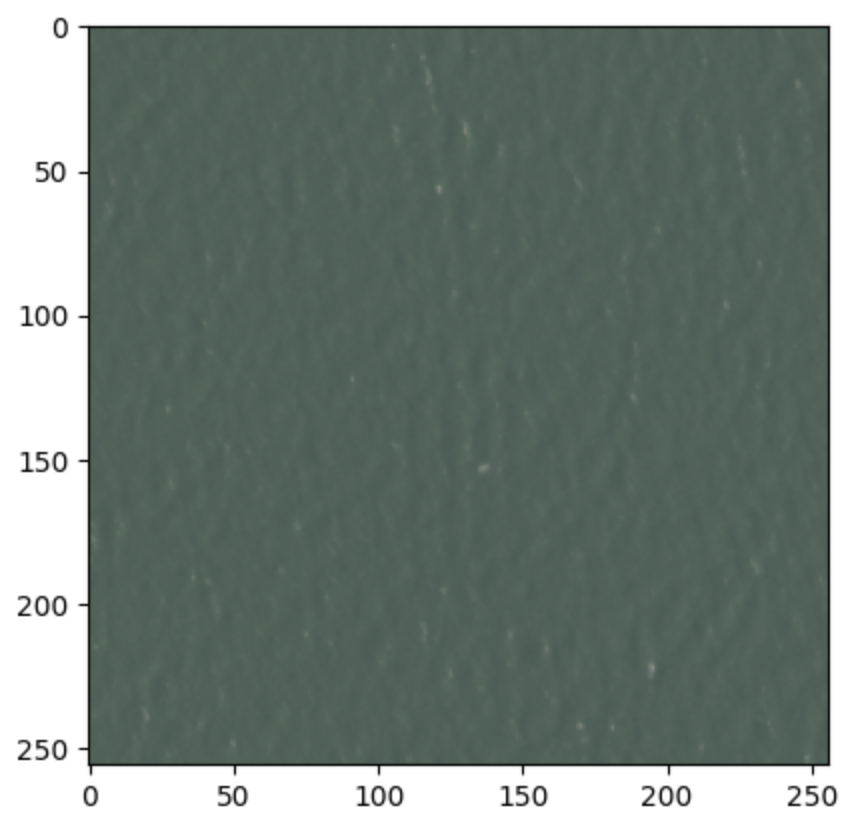

![](<img src="attachment:691a125f-6ab5-4d3b-a9ae-88467b0de51b.png" style="width:300px;"/>)


Below are some functions we will rely on to prepare the data cubes, generate embeddings, and plot subsets of the chipped images for visualization purposes.

In [22]:
def plot_rgb(stack):
    """
    Plot the RGB bands of the given stack.

    Parameters:
    stack (xarray.DataArray): The input data array containing band information.
    """
    stack.sel(band=[1, 2, 3]).plot.imshow(rgb="band", vmin=0, vmax=2000, col_wrap=6)
    plt.show()

In [23]:
def normalize_latlon(lat, lon):
    """
    Normalize latitude and longitude to a range between -1 and 1.

    Parameters:
    lat (float): Latitude value.
    lon (float): Longitude value.

    Returns:
    tuple: Normalized latitude and longitude values.
    """
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

In [24]:
def load_model(ckpt, device="cuda"):
    """
    Load a pretrained Clay model from a checkpoint.

    Parameters:
    ckpt (str): Path to the model checkpoint.
    device (str): Device to load the model onto (default is 'cuda').

    Returns:
    model: Loaded model.
    """
    torch.set_default_device(device)
    model = ClayMAEModule.load_from_checkpoint(
        ckpt, metadata_path="../configs/metadata.yaml", shuffle=False, mask_ratio=0
    )
    model.eval()
    return model.to(device)

In [ ]:
def prep_datacube(image, lat, lon, date, gsd, device):
    """
    Prepare a data cube for model input.

    Parameters:
    image (np.array): The input image array.
    lat (float): Latitude value for the location.
    lon (float): Longitude value for the location.
    device (str): Device to load the data onto.

    Returns:
    dict: Prepared data cube with normalized values and embeddings.
    """
    platform = "naip"

    # Extract mean, std, and wavelengths from metadata
    metadata = Box(yaml.safe_load(open("../configs/metadata.yaml")))
    mean = []
    std = []
    waves = []
    bands = ["red", "green", "blue", "nir"]
    for band_name in bands:
        mean.append(metadata[platform].bands.mean[band_name])
        std.append(metadata[platform].bands.std[band_name])
        waves.append(metadata[platform].bands.wavelength[band_name])

    transform = v2.Compose(
        [
            v2.Normalize(mean=mean, std=std),
        ]
    )

    # Prep datetimes embedding
    times = normalize_timestamp(date)
    week_norm = times[0]
    hour_norm = times[1]

    # Prep lat/lon embedding
    latlons = normalize_latlon(lat, lon)
    lat_norm = latlons[0]
    lon_norm = latlons[1]

    # Prep pixels
    pixels = torch.from_numpy(image.astype(np.float32))
    pixels = transform(pixels)
    pixels = pixels.unsqueeze(0)

    # Prepare additional information
    return {
        "pixels": pixels.to(device),
        "time": torch.tensor(
            np.hstack((week_norm, hour_norm)),
            dtype=torch.float32,
            device=device,
        ).unsqueeze(0),
        "latlon": torch.tensor(
            np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
        ).unsqueeze(0),
        "gsd": torch.tensor(gsd, device=device),
        "waves": torch.tensor(waves, device=device),
    }

In [ ]:
def generate_embeddings(model, datacube):
    """
    Generate embeddings from the model.

    Parameters:
    model (ClayMAEModule): The pretrained model.
    datacube (dict): Prepared data cube.

    Returns:
    numpy.ndarray: Generated embeddings.
    """
    with torch.no_grad():
        unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

    # The first embedding is the class token, which is the
    # overall single embedding.
    return unmsk_patch[:, 0, :].cpu().numpy()

In [ ]:
outdir_embeddings = "../data/embeddings/"
os.makedirs(outdir_embeddings, exist_ok=True)

### Load the trained Clay v1 model

In [ ]:
# Download the pretrained model from
# https://huggingface.co/made-with-clay/Clay/blob/main/clay-v1-base.ckpt
# and put it in a checkpoints folder.
model = load_model(
    ckpt="../checkpoints/clay-v1-base.ckpt",
    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
)

### Generate embeddings

In [ ]:
embeddings = []
i = 0
for tile, bounding_box in zip(chip_images, chip_bounds):
    date = datetime.datetime.strptime(f"{YEAR}-06-01", "%Y-%m-%d")
    gsd = 0.6

    lon, lat = box(bounding_box[0], bounding_box[1], bounding_box[2], bounding_box[3]).centroid.coords[0]

    datacube = prep_datacube(
        np.array(tile), lat, lon, pd.to_datetime(f"{YEAR}-06-01"), gsd, model.device
    )
    embeddings_ = generate_embeddings(model, datacube)
    embeddings.append(embeddings_)

    data = {
        "source_url": str(i),
        "date": pd.to_datetime(arg=date, format="%Y-%m-%d"),
        "embeddings": [np.ascontiguousarray(embeddings_.squeeze())],
        "image": [np.ascontiguousarray(np.array(tile.transpose(1, 2, 0)).flatten())],
    }

    # Create the GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=[bounding_box], crs="EPSG:4326")

    outpath = f"{outdir_embeddings}/{i}.gpq"
    gdf.to_parquet(path=outpath, compression="ZSTD", schema_version="1.0.0")
    print(
        f"Saved {len(gdf)} rows of embeddings of "
        f"shape {gdf.embeddings.iloc[0].shape} to {outpath}"
    )
    i += 1

In [ ]:
print(f"Created {len(embeddings)} embeddings of shape {embeddings[0].shape[1]}")

### Run a similarity search to identify similar embeddings
We will select a random index to search with and plot the corresponding RGB images from the search results. 

In [ ]:
# Connect to the embeddings database
db = lancedb.connect(outdir_embeddings)

In [ ]:
# Data for DB table
data = []
# Dataframe to find overlaps within
gdfs = []
idx = 0
for emb in glob.glob(f"{outdir_embeddings}/*.gpq"):
    gdf = gpd.read_parquet(emb)
    gdf["year"] = gdf.date.dt.year
    gdf["tile"] = gdf["source_url"]
    gdf["idx"] = idx
    gdf["box"] = [shapely.geometry.box(*geom.bounds) for geom in gdf.geometry]
    gdfs.append(gdf)

    for _, row in gdf.iterrows():
        data.append(
            {
                "vector": row["embeddings"],
                "path": row["source_url"],
                "tile": row["tile"],
                "date": row["date"],
                "year": int(row["year"]),
                "idx": row["idx"],
                "box": row["box"].bounds,
                "image": row["image"],
            }
        )
    idx += 1

In [ ]:
# Combine the geodataframes into one
embeddings_gdf = pd.concat(gdfs, ignore_index=True)

In [ ]:
# Drop existing table if any
try:
    db.drop_table("clay-v001")
except FileNotFoundError:
    pass
db.table_names()

In [ ]:
# Create a new table with the embeddings data
tbl = db.create_table("clay-v001", data=data, mode="overwrite")

In [ ]:
# Select a random embedding for the search query
idx = random.randint(0, len(embeddings_gdf))
v = tbl.to_pandas().iloc[idx]["vector"]

In [ ]:
# Perform the search
search_x_images = 6
result = tbl.search(query=v).limit(search_x_images).to_pandas()

In [ ]:
result

In [ ]:
def plot(df, cols=4, save=False):
    """
    Plot the top similar images.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the search results.
    cols (int): Number of columns to display in the plot.
    """
    fig, axs = plt.subplots(1, cols, figsize=(20, 10))
    i = 0
    for ax, (_, row) in zip(axs.flatten(), df.iterrows()):
        # row = df.iloc[i]
        chip = np.array(row["image"]).reshape(256, 256, 4)
        chip = chip[:, :, :3]
        ax.imshow(chip)
        ax.set_title(f"{row['idx']}")
        i += 1
    plt.tight_layout()
    if save:
        fig.savefig("similar.png")

In [ ]:
# Plot the top similar images
plot(result, search_x_images)

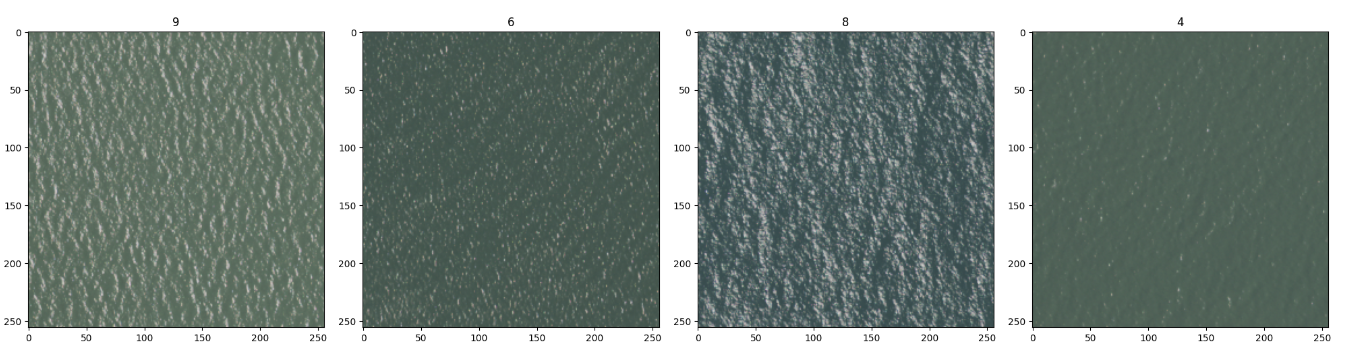